In [2]:
import sys
import numpy as np
import scipy.interpolate as si
import os
import scipy.optimize
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser

sys.path.append("../src")  # relative path from notebooks/ to src/
import JCM_models.xray_compounds as xc
import JCM_models.jcm_plotting_utils as JCMgrid
from JCM_models import Shape, ShapeGenerator, Source, Cartesian, PostProcess, SimulationResult

#import geo_3 as geometry
#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')


#jcm_root = join(home,'JCMwave/JCMsuite_6_2_1/ThirdPartySupport/Python')
#jcm_root = join(home,'JCMwave/JCMsuite_6_4_8/ThirdPartySupport/Python')
jcm_root = join(home,'JCMwave/JCMsuite_6_6_4/ThirdPartySupport/Python')
sys.path.append(jcm_root)
import jcmwave

import pint
unit = pint.UnitRegistry()

#import pythia.Misc as MISC

#from paramiko import SSHClient

#import json

import pandas as pd

import pickle 

#import xraylib

import time

import matplotlib as mpl
import matrixmethod as mm
mpl.rcParams['font.family'] = ['sans']
mpl.rcParams['font.serif'] = ['DejaVu Sans']
jcmwave.daemon.shutdown()

In [2]:
jcmwave.daemon.shutdown()
jcmwave.daemon.add_workstation(
    Hostname="localhost",
    # Login='andrle01',
    Multiplicity=3,
    NThreads=12,
)

[1050377119, 1202238149, 1553387092]

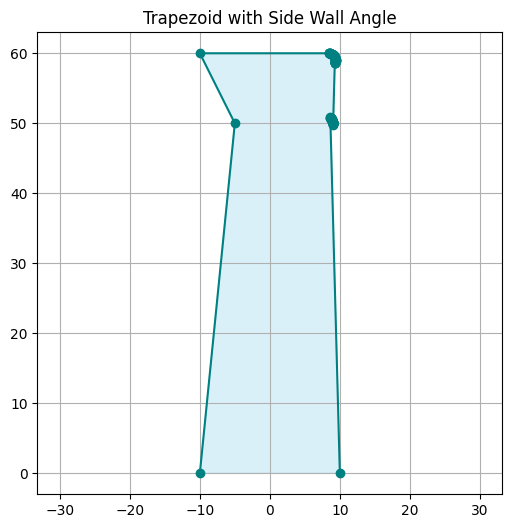

[50, 10]
🔷 Shape: Stack_trapezoids
• Height: [50, 10]
• Width: [20, 10, 20]
• Layer transitions:
   - Layer 0: height 50, bottom width 20, top width 10
   - Layer 1: height 10, bottom width 10, top width 20
• Rounded corners:
   - Corner 1 at (5.00, 50.00) → radius 2.0
   - Corner 2 at (10.00, 60.00) → radius 1.0
• Centered option available via `.centered()`


In [3]:


# Example usage
params = {'height': [50,10], 'width': [20,10,20],'corner_radii': {1: 2.0, 2: 1.0}}
#params = {'height': 50, 'width': 20}#,'corner_radii': {3: 2.0, 2: 1.0}}
#params = {'control_points':[(15,0),(10,10),(-10,10),(-10,0)]}
gen = ShapeGenerator('stack_trapezoids', params)

gen.plot(title="Trapezoid with Side Wall Angle")
print(gen.describe())

In [3]:

    
s_nm = Source(532, [1, 0], 45, 0, unit='nm')
s_eV = Source(2.33, [0, 1], 60, 90, unit='eV',incidence='FromBelow')

print(s_nm.describe())
print()
print(s_eV.describe())




🔆 Source description:
• Wavelength: 5.32e-07
• Polarization: [1, 0] → S-polarized
• Angle of incidence: 45°
• Azimuthal angle (phi): 0°
• Incidence direction: FromAbove
• Type: PlaneWave

🔆 Source description:
• Wavelength: 5.32121023318456e-07
• Polarization: [0, 1] → P-polarized
• Angle of incidence: 60°
• Azimuthal angle (phi): 90°
• Incidence direction: FromBelow
• Type: PlaneWave


In [4]:
thick = np.array([20,35,1.2] )
rough = np.array([0,0,0,0] )
wl = [13.5]
ang_deg = np.array([90])#np.linspace(0.1, 2.0, 10001)
ang = np.deg2rad(ang_deg)
nk_resist = [1-0.023+0.00419j]
nk_Chaucer = [1-0.0226+0.0048j]
nk_SOG = [1-0.0195-0.006j]
nk_sub = np.conjugate(xc.refractive_index('Si',wl* unit.nm,density=2.33))
nk_sub_oxid = np.conjugate(xc.refractive_index('SiO2',wl* unit.nm,density=2.0929729034348785))

thick_noUL = np.array([20,1.2] )
rough_noUL = np.array([0,0,0] )
keys = {'uol1': 1e-9,
        'fem_deg': 4,}

#keys['energy'] = energy[i_taken_energy].to(unit.keV, 'sp').magnitude
#print(keys['energy'])
keys['pol'] = [1, 0] #1,0 s pol 0,1 p pol
keys['lamb'] = wl[0] * 1e-9
keys['slc'] = 1


pitch = 50
substrate_offset = 30
vacuum_offset = 30
y = 60
slc = 1

computional_domain = ShapeGenerator('rectangle', {'height':y,'width':pitch},offset_y=-15).flatten(centered=True)
substrate = ShapeGenerator('rectangle', {'height':10,'width':pitch},offset_y=-10).flatten(centered=True)
substrate_oxide = ShapeGenerator('rectangle', {'height':2,'width':pitch}).flatten(centered=True)
bsplines = ShapeGenerator('bsplines', {'control_points':[(15,0),(10,10),(-10,10),(-10,0)]},offset_y=30).flatten(centered=True)
trapzoid_stack = ShapeGenerator('stack_trapezoids', {'height': [20,10], 'width': [20,10,20],'corner_radii': {3: 2.0, 2: 2.0}}).flatten(centered=True)

shape = [
    Shape('ComputationalDomain',domain_id = 1,priority=-1,side_length_constraint=slc,points=computional_domain, nk = 1,boundary = ['Transparent','Periodic','Transparent','Periodic'] ),
    Shape('substrate',domain_id = 2,priority=1,side_length_constraint=slc,points=substrate, nk = nk_sub ),
    Shape('substrate_oxide',domain_id = 3,priority=2,side_length_constraint=slc,points=substrate_oxide, nk = nk_sub_oxid ),
    Shape('UL',domain_id = 4,priority=2,side_length_constraint=slc,points=bsplines, nk = nk_SOG ),
    Shape('resist',domain_id = 5,priority=2,side_length_constraint=slc,points=trapzoid_stack, nk = nk_resist ),
]
shape[0].domain_id
keys['shape']=shape
keys['source']=[s_eV]
keys['energy_index'] = 0

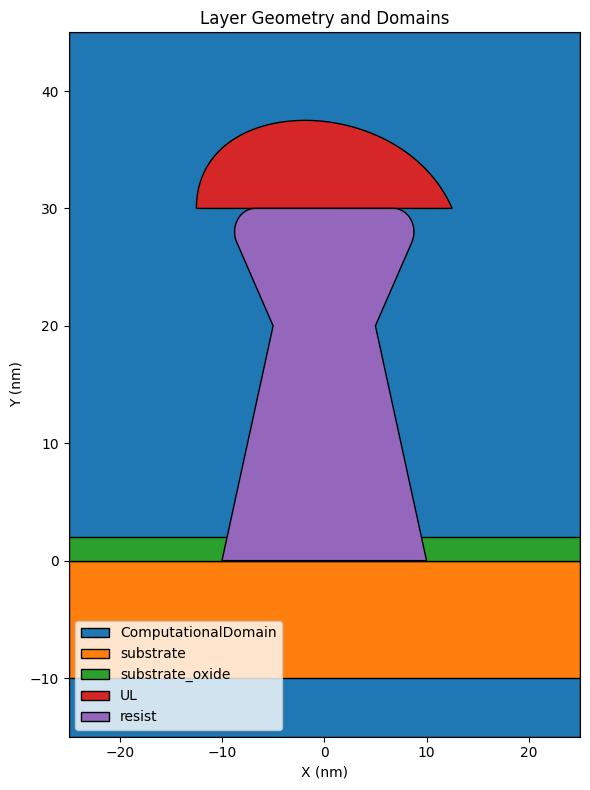

In [5]:
import matplotlib.pyplot as plt

# Create a shared figure and axis
fig, ax = plt.subplots(figsize=(6, 8))

# Plot each shape
for s in shape[:]:
    #s.plot(ax=ax)
    s.plot_colored_geometry(ax=ax)

# Final touches
ax.set_xlim(-pitch/2, pitch/2)
ax.set_ylim(-15, 45)
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_title("Layer Geometry and Domains")
ax.legend()
#ax.grid(True)
plt.tight_layout()
plt.show()

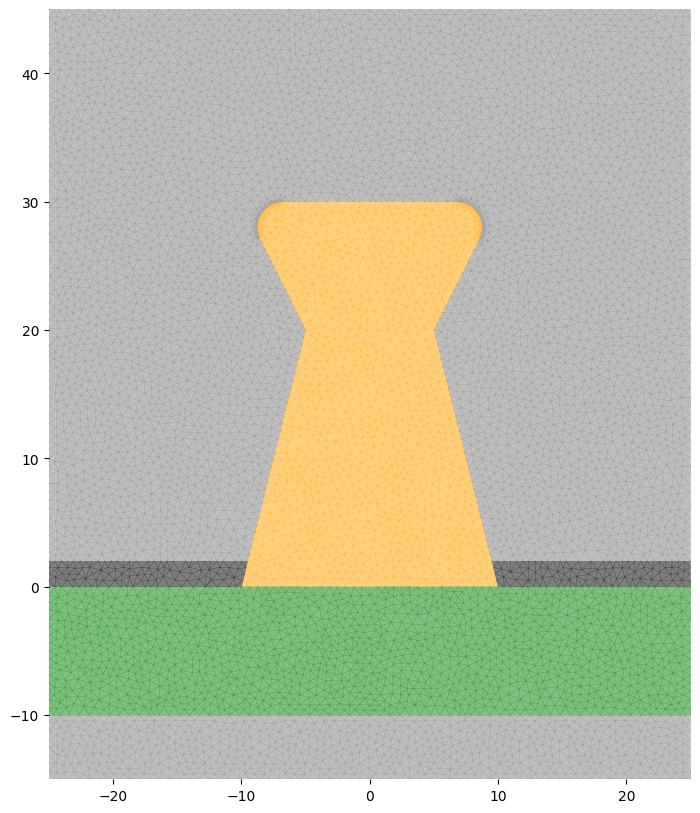

In [5]:
jcmwave.geo("../JCM_clean/",keys=keys)
fig, ax = plt.subplots(figsize=(10, 10))

JCMgrid.plot_grid(
    "../JCM_clean/grid.jcm",
    ax=ax,
    colors={1: "grey", 2: "green", 3: "black", 4: "blue", 5: "orange", 6: "pink"},
    alpha=0.5,
    lw=0.2,
)
ax.set_xlim(-pitch/2, pitch/2)
ax.set_ylim(-15, 45)
ax.set_frame_on(False)
# remove ticks and labels
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_aspect("equal")

In [10]:

    
cart = Cartesian(spacing=0.1e-9)
cart = Cartesian(n_grid_points_x=100,n_grid_points_y=100)
print(cart.to_jcm())

pp1 = PostProcess(
    mode="ExportFields",
    field_bag_path="project_results/fieldbag.jcm",
    output_file_name="project_results/fieldbag_near_field_xy.jcm",
    output_quantity="ElectricFieldStrength", #"ElectricFieldEnergyDensity"# "ElectricFieldStrength"
    cartesian=cart
)

pp2 = PostProcess(
    mode="FourierTransform",
    field_bag_path="project_results/fieldbag.jcm",
    output_file_name="project_results/ft.jcm",
    normal_direction="Y"
)

print(pp1.to_jcm())
print()
print(pp2.to_jcm())


  Cartesian {
    NGridPointsX = 100
    NGridPointsY = 100
  }
PostProcess {
  ExportFields {
    FieldBagPath = "project_results/fieldbag.jcm"
    OutputFileName = "project_results/fieldbag_near_field_xy.jcm"
    OutputQuantity = "ElectricFieldStrength"
    Cartesian {
      NGridPointsX = 100
      NGridPointsY = 100
    }
  }
}

PostProcess {
  FourierTransform {
    FieldBagPath = "project_results/fieldbag.jcm"
    OutputFileName = "project_results/ft.jcm"
    NormalDirection = Y
  }
}


In [47]:
ids = []

keys['slc'] = 0.7

keys['phi']=90
keys['angle_of_incidence']= 0 #-82 #87.285796
keys['postprocess']=[pp1,pp2]
s_eV = Source(lam=200, polarization=[1, 0], angle_of_incidence=45, phi=45, unit='nm',incidence='FromBelow')
keys['source']=[s_eV]
#results = jcmwave.solve("../JCM_clean/project.jcmpt",keys=keys)
ids.append(
    jcmwave.solve('../JCM_clean/project.jcmpt',  keys=keys, temporary=True)
)
#results = [results]

results, logs = jcmwave.daemon.wait(ids, verbose=False)

In [50]:
results[0]

[{'file': '/tmp/__JCMwave__tdxen6li/project_results/fieldbag.jcm',
  'computational_costs': {'title': 'ComputationalCosts',
   'header': {'AccumulatedCPUTime': 3004.995544,
    'AccumulatedTotalTime': 2317.006505996},
   'Level': array([0], dtype=int32),
   'Unknowns': array([4502377], dtype=int32),
   'CpuTime': array([3004.437245]),
   'CpuPerUnknown': array([0.0006673]),
   'TotalTime': array([2316], dtype=int32),
   'SystemMemory_GB': array([9.67116165]),
   'MaxNodeSystemMemory_GB': array([9.67116165]),
   'TotalMemory_GB': array([12.66410065]),
   'MaxNodeTotalMemory_GB': array([12.66410065]),
   'CpuTimeAssembling': array([1122.169725]),
   'CpuTimeSolve': array([1757.141791]),
   'CpuTimeInnerNodeUpdate': array([11.916079]),
   'TotalTimeAssembling': array([835.54805217]),
   'TotalTimeSolve': array([1394.82056044]),
   'TotalTimeInnerNodeUpdate': array([1.01924644]),
   'FEDegree0_Percentage': array([0.]),
   'FEDegree1_Percentage': array([0.]),
   'FEDegree2_Percentage': arra

In [65]:
import numpy as np
from typing import Any, Dict, List, Optional
import matplotlib.pyplot as plt


📂 SimulationResult from /tmp/__JCMwave__tdxen6li/project_results/fieldbag.jcm
📊 ComputationalCosts: CPU=3005.00s, Total=2317.01s, Unknowns=4502377
FieldData[0]: 🌐 FieldData: Quantity=ElectricFieldStrength, Shape=(100, 100, 3), Grid points=(100, 100)
Fourier[0]: 🔊 ElectricFieldStrength_PropagatingFourierCoefficients: NormalDirection=Y, K=(1, 3)
----------------------------------------
Orders: [-1  0  1]
Raw intensities: [0.         0.49768821 0.        ]
Corrected intensities: [0.         0.49768821 0.        ]


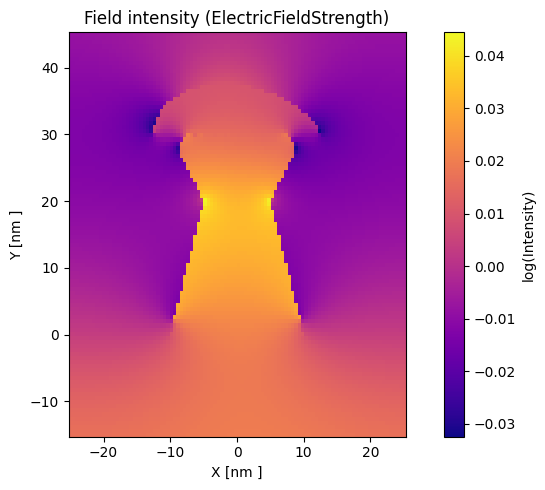

In [68]:
sim_results = SimulationResult.from_list(results)

for res in sim_results:
    print(res.summary())
    print("-" * 40)
    fd = res.field_data[0]   # your FieldData object
    fd.plot_field(index=0, log=True, cmap="plasma")

    fo = res.fourier[0].compute_order_intensities(orders_uni=[-1, 0, 1])
    print("Orders:", fo["orders"])
    print("Raw intensities:", fo["raw"])
    print("Corrected intensities:", fo["corrected"])

df = res.fourier[0].to_dataframe()


In [59]:
df

,order,Kx,Ky,Kz,Kx_in,Ky_in,Kz_in,Intensity_calc,k_norm,cos_theta_in,cos_theta_out,cos_phi_out,Intensity_calc_corrected
0,0,1.570796e+07,2.221441e+07,-1.570796e+07,1.570796e+07+0.000000e+ 00j,2.221441e+07+0.000000e+ 00j,-1.570796e+07+0.000000e+ 00j,0.995347,3.141593e+07,-0.5+0.0j,-0.5,1.0,0.995347+0.000000j


In [40]:
raw = results  # your giant list of dicts

# First dict: computational costs
comp = ComputationalCosts(**raw[0]["computational_costs"])

# Second dict: field data
fd = FieldData(
    field=raw[1]["field"],
    grid=raw[1]["grid"],
    X=raw[1]["X"],
    Y=raw[1]["Y"],
    Z=raw[1]["Z"],
    header=raw[1]["header"]
)

# Third dict: Fourier coefficients
fourier = FourierCoefficients(
    title=raw[2]["title"],
    header=raw[2]["header"],
    K=raw[2]["K"],
    N1=raw[2]["N1"],
    N2=raw[2]["N2"],
    ElectricFieldStrength=raw[2]["ElectricFieldStrength"]
)

# Wrap into SimulationResult
result = SimulationResult(
    file=raw[0]["file"],
    computational_costs=comp,
    field_data=fd,
    fourier=fourier
)

print(result.summary())

📂 SimulationResult from /home/kas/Projects/JCMwave_modeling/JCM_clean/project_results/fieldbag.jcm
📊 ComputationalCosts: CPU=176.16s, Total=205.82s, Unknowns=1006745
🌐 FieldData: Quantity=ElectricFieldStrength, Shape=(100, 100, 3), Grid points=(100, 100)
🔊 ElectricFieldStrength_PropagatingFourierCoefficients: NormalDirection=Y, K=(1, 3)


(<Figure size 800x500 with 2 Axes>,
 <Axes: title={'center': 'Field intensity (ElectricFieldStrength)'}, xlabel='X [nm ]', ylabel='Y [nm ]'>)

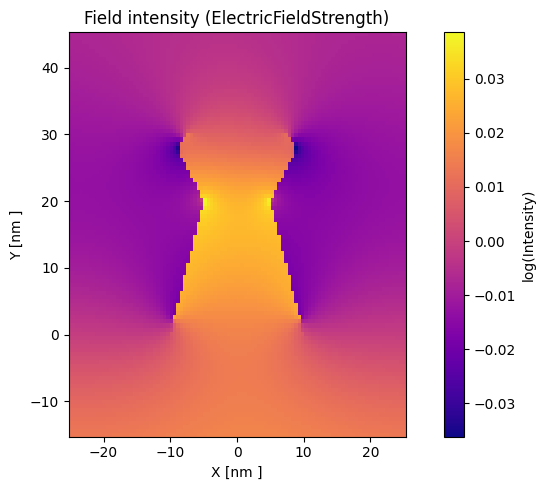

In [36]:
fd = result.field_data   # your FieldData object
fd.plot_field(index=0, log=True, cmap="plasma")


In [41]:
fourier = FourierCoefficients(
    title=raw[2]["title"],
    header=raw[2]["header"],
    K=raw[2]["K"],
    N1=raw[2]["N1"],
    N2=raw[2]["N2"],
    ElectricFieldStrength=raw[2]["ElectricFieldStrength"]
)

res = fourier.compute_order_intensities(orders_uni=[-1, 0, 1])
print("Orders:", res["orders"])
print("Raw intensities:", res["raw"])
print("Corrected intensities:", res["corrected"])

Orders: [-1  0  1]
Raw intensities: [0.         0.49696097 0.        ]
Corrected intensities: [0.         0.49696097 0.        ]


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'ElectricFieldStrength_PropagatingFourierCoefficients (raw)'}, xlabel='K_y (1/m)', ylabel='Intensity'>)

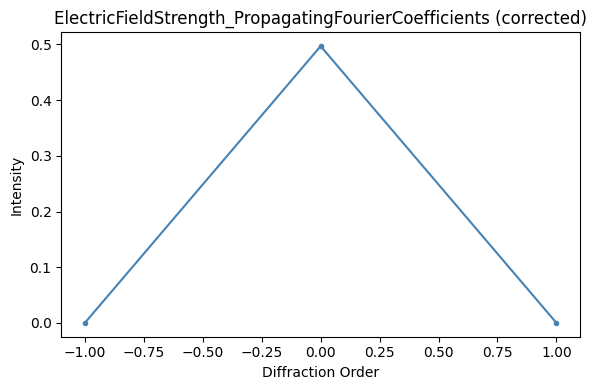

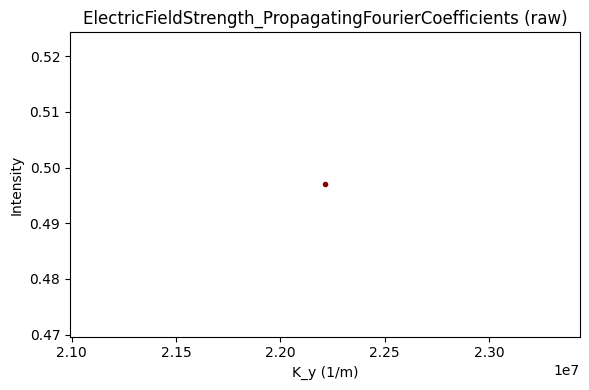

In [42]:
# FourierCoefficients object already created as `fourier`
# Plot order vs corrected intensity
fourier.plot_intensities(orders_uni=[-1, 0, 1], use_k=False, corrected=True, color="steelblue")

# Plot K_y vs raw intensity
fourier.plot_intensities(orders_uni=[-1, 0, 1], use_k=True, corrected=False, color="darkred")

In [43]:
fourier = FourierCoefficients(
    title=raw[2]["title"],
    header=raw[2]["header"],
    K=raw[2]["K"],
    N1=raw[2]["N1"],
    N2=raw[2]["N2"],
    ElectricFieldStrength=raw[2]["ElectricFieldStrength"]
)

df = fourier.to_dataframe()
print(df.head())

   order            Kx            Ky            Kz  \
0      0  1.570796e+07  2.221441e+07 -1.570796e+07   

                                            Kx_in  \
0  1.570796e+07+0.000000e+                    00j   

                                            Ky_in  \
0  2.221441e+07+0.000000e+                    00j   

                                            Kz_in  Intensity_calc  \
0 -1.570796e+07+0.000000e+                    00j        0.993886   

         k_norm  cos_theta_in  cos_theta_out  cos_phi_out  \
0  3.141593e+07     -0.5+0.0j           -0.5          1.0   

   Intensity_calc_corrected  
0        0.993886+0.000000j  
